import modules

In [179]:
import sys

sys.path.insert(0, "../../si_model")
from typing import Tuple

import torch as t
from torch.distributions import uniform, normal
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker

import imageio

from tqdm import tqdm

from model import init_grids, model
from utils import chop_and_shuffle_data, pre_process
from likelihoods import spread_likelihood, transition_likelihood, neg_log_likelihood
from distance_funcs import mean_sq_distance


In [108]:
mpl.rcParams['axes.linewidth'] = 1
mpl.rcParams["text.usetex"] = True
mpl.rcParams["font.family"] = "Helvetica"
mpl.rcParams["font.size"] = 12
mpl.rcParams["text.latex.preamble"] = "\\usepackage{amssymb}"

# Experiment: Using Gumbel-Softmaxing to build a differentiable SI model

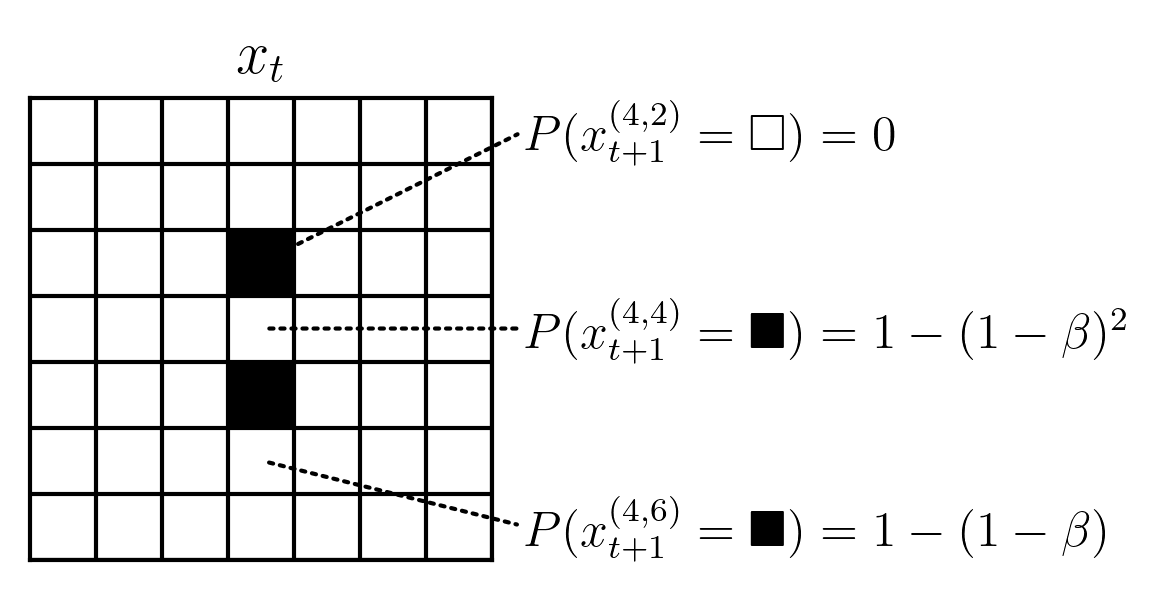

In [305]:
grid = t.zeros(7,7)
grid[2,3] = 1
grid[4,3] = 1
fig, ax = plt.subplots(figsize=(3,2), dpi=300)

ax.imshow(grid, cmap="Greys", interpolation="nearest", vmin=0, vmax=1)
ax.grid(color='black', linewidth=1)
ax = plt.gca()
ax.set_xticks(np.arange(.5, 7.5, 1))
ax.set_yticks(np.arange(.5, 7.5, 1))
for tic in ax.xaxis.get_major_ticks():
    tic.tick1line.set_visible(False)
    tic.tick2line.set_visible(False)
    tic.label1.set_visible(False)
    tic.label2.set_visible(False)
for tic in ax.yaxis.get_major_ticks():
    tic.tick1line.set_visible(False)
    tic.tick2line.set_visible(False)
    tic.label1.set_visible(False)
    tic.label2.set_visible(False)
    
plt.text(7,6.3,"$P(x^{(4,6)}_{t+1} = \\blacksquare) = 1 - (1 - \\beta)$")
plt.text(7,3.3,"$P(x^{(4,4)}_{t+1} = \\blacksquare) = 1 - (1 - \\beta)^2$")
plt.text(7,0.3,"$P(x^{(4,2)}_{t+1} = \\square) = 0$")

plt.annotate('',
             xy = (7,0),
             xytext = (3, 2),
             arrowprops = {
                 'arrowstyle': '-', 'ls': 'dotted'
             },
             horizontalalignment = 'center',
             annotation_clip=False)
plt.annotate('',
             xy = (7,3),
             xytext = (3, 3),
             arrowprops = {
                 'arrowstyle': '-', 'ls': 'dotted'
             },
             horizontalalignment = 'center',
             annotation_clip=False)
plt.annotate('',
             xy = (7,6),
             xytext = (3, 5),
             arrowprops = {
                 'arrowstyle': '-', 'ls': 'dotted'
             },
             horizontalalignment = 'center',
             annotation_clip=False)
plt.title("$x_t$")
plt.show()

## 1. Define the model functions

In [144]:
def model_gumbel(grids: t.Tensor, beta: t.Tensor) -> t.Tensor:
    healthy_mask = 1 - grids
    # calculate the likelihood of spread 
    likelihoods = spread_likelihood(grids, beta)
    #print(likelihoods.flatten().unsqueeze(1).shape)
    flattened = likelihoods.flatten().unsqueeze(0)
    #print(t.concat([t.log(flattened), t.log(1-flattened)], dim=0).T.shape)
    update = t.nn.functional.gumbel_softmax(t.concat([t.log(flattened), t.log(1-flattened)]).T, hard=True)
    #print(update.shape)
    unflattened = update[:,0].unflatten(dim=0, sizes=grids.shape) * healthy_mask
    # apply the update to the current state
    return grids + unflattened

## 2. Dataset generated from a distribution of $\beta$ values

### create custom torch dataset

In [147]:
class CustomDataset(Dataset):
    def __init__(self, beta_mu=None, beta_sigma=None, num_sequences=None, steps_per_sequence=None, grid_size=None, load_path=None):
        if load_path:
            self.data = t.load(load_path)
        else:
            sequences = t.zeros((num_sequences, steps_per_sequence, grid_size, grid_size))
            self.betas = []

            for seq_idx in tqdm(range(num_sequences)):
                sequence = init_grids(grid_size,1)
                for step_idx in range(steps_per_sequence):
                    beta = t.clip(normal.Normal(beta_mu, beta_sigma).sample(), 0, 1)
                    sequences[seq_idx,step_idx,:,:] = sequence
                    sequence = model_gumbel(sequence, beta)
                    self.betas.append(beta.detach().cpu())

            dataset = chop_and_shuffle_data(sequences, shuffle=False)
            self.data = pre_process(dataset)

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return self.data[idx], 0

In [175]:
beta_mu = 0.5
beta_sigma = 0.1
num_sequences = 100
steps_per_sequence = 30
grid_size = 64

training_data = CustomDataset(beta_mu=beta_mu, beta_sigma=beta_sigma, num_sequences=num_sequences, steps_per_sequence=steps_per_sequence, grid_size=grid_size)
len(training_data)
training_loader = DataLoader(training_data, batch_size=32, shuffle=True)
t.save(training_data.data, "./data/training_set.pt")

100%|██████████| 100/100 [00:06<00:00, 14.72it/s]


remove 0 entries from the dataset
torch.Size([2900, 2, 64, 64])


In [177]:
grids = init_grids(grid_size, 1)
for i in range(steps_per_sequence):
  fig, axs = plt.subplots(figsize=(3,3), dpi=300)
  axs.imshow(grids[0], cmap="Greys", interpolation="nearest", vmin=0, vmax=1)
  axs.get_xaxis().set_visible(False)
  axs.get_yaxis().set_visible(False)
  fig.tight_layout()
  fig.savefig(f"./images/sequence/{i}.png")
  plt.close(fig)
  beta = t.clip(normal.Normal(beta_mu, beta_sigma).sample(), 0, 1)
  grids = model_gumbel(grids, beta)

In [180]:
images = []
for i in range(steps_per_sequence):
    images.append(imageio.imread(f"./images/sequence/{i}.png"))
imageio.mimsave(f"./gif/{beta_mu}_{beta_sigma}.gif", images)

/tmp/ipykernel_6880/1428391935.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f"./images/sequence/{i}.png"))


In [206]:
def remove_ticklines(ax):
    for tic in ax.xaxis.get_major_ticks():
        tic.tick1line.set_visible(False)
        tic.tick2line.set_visible(False)
        tic.label1.set_visible(False)
        tic.label2.set_visible(False)
    for tic in ax.yaxis.get_major_ticks():
        tic.tick1line.set_visible(False)
        tic.tick2line.set_visible(False)
        tic.label1.set_visible(False)
        tic.label2.set_visible(False)

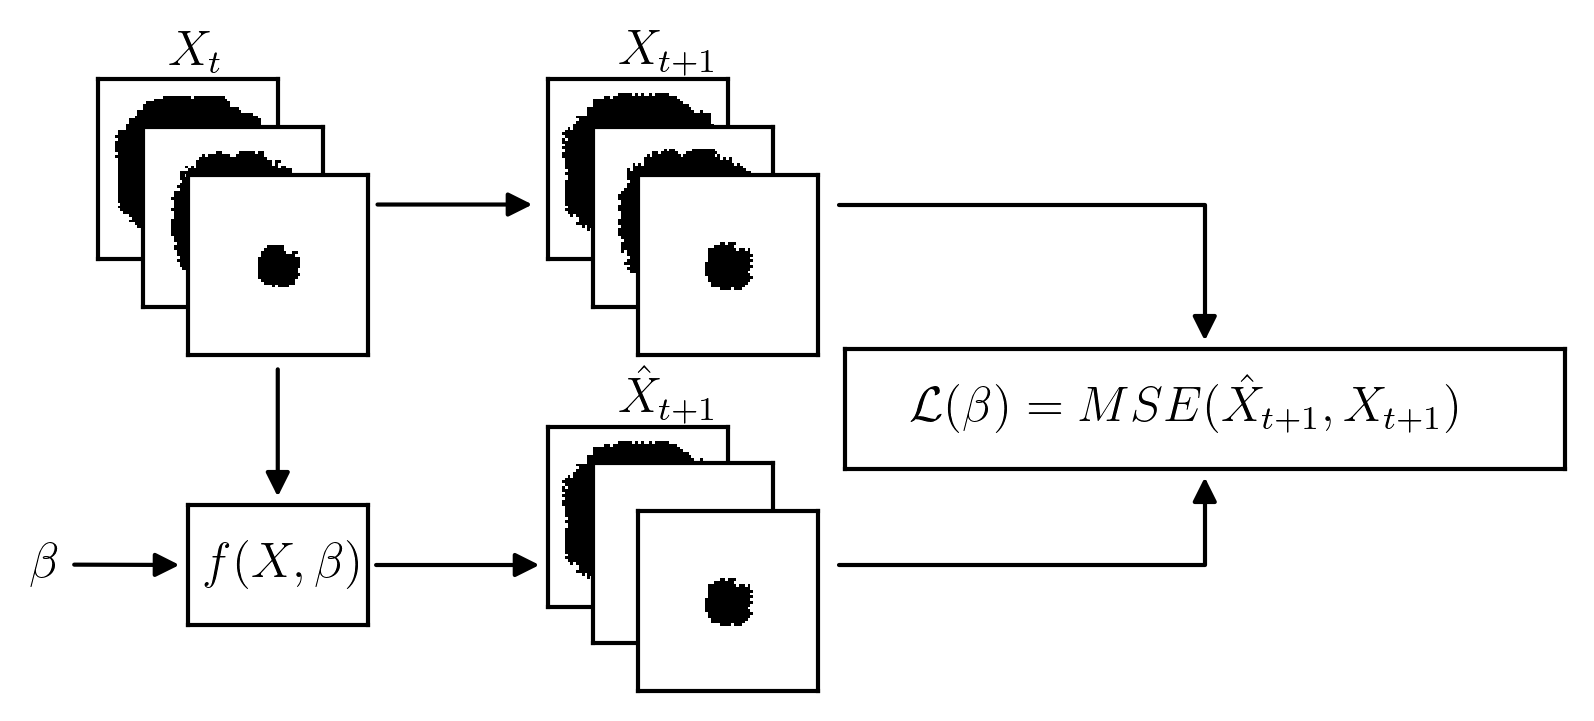

In [423]:
fig = plt.figure(figsize=(3, 2), dpi=300)

ax1 = fig.add_axes([0.22, -0.01, 0.2, 0.2])
remove_ticklines(ax1)
ax1.text(0.09,0.4,"$f(X,\\beta)$")
ax1.annotate('',
    xy = (0.5,1),
    xytext = (0.5, 2.2),
    arrowprops = {
        'arrowstyle': '-|>',
        'color': "black"
    },
    horizontalalignment = 'center',
    annotation_clip=False
)
ax1.annotate('$\\beta$',
    xy = (0,0.5),
    xytext = (-0.8, 0.4),
    arrowprops = {
        'arrowstyle': '-|>',
        'color': "black"
    },
    horizontalalignment = 'center',
    annotation_clip=False
)


ax2 = fig.add_axes([0.07, 0.6, 0.3, 0.3])
remove_ticklines(ax2)
ax2.text(25., -5.5, "$X_t$")
ax3 = fig.add_axes([0.12, 0.52, 0.3, 0.3])
remove_ticklines(ax3)
ax4 = fig.add_axes([0.17, 0.44, 0.3, 0.3])
remove_ticklines(ax4)

ax2.imshow(training_data[200][0][0], cmap="Greys", interpolation="nearest", vmin=0, vmax=1)
ax3.imshow(training_data[400][0][0], cmap="Greys", interpolation="nearest", vmin=0, vmax=1)
ax4.imshow(training_data[500][0][0], cmap="Greys", interpolation="nearest", vmin=0, vmax=1)

ax5 = fig.add_axes([0.57, 0.6, 0.3, 0.3])
remove_ticklines(ax5)
ax5.text(25., -5.5, "$X_{t+1}$")
ax6 = fig.add_axes([0.62, 0.52, 0.3, 0.3])
remove_ticklines(ax6)
ax7 = fig.add_axes([0.67, 0.44, 0.3, 0.3])
remove_ticklines(ax7)

ax5.imshow(training_data[200][0][1], cmap="Greys", interpolation="nearest", vmin=0, vmax=1)
ax6.imshow(training_data[400][0][1], cmap="Greys", interpolation="nearest", vmin=0, vmax=1)
ax7.imshow(training_data[500][0][1], cmap="Greys", interpolation="nearest", vmin=0, vmax=1)

ax8 = fig.add_axes([0.57, 0.02, 0.3, 0.3])
remove_ticklines(ax8)
ax8.text(25., -5.5, "$\hat{X}_{t+1}$")
ax9 = fig.add_axes([0.62, -0.04, 0.3, 0.3])
remove_ticklines(ax9)
ax10 = fig.add_axes([0.67, -.12, 0.3, 0.3])
remove_ticklines(ax10)

ax8.imshow(training_data[200][0][1], cmap="Greys", interpolation="nearest", vmin=0, vmax=1)
ax9.imshow(training_data[300][0][1], cmap="Greys", interpolation="nearest", vmin=0, vmax=1)
ax10.imshow(training_data[500][0][1], cmap="Greys", interpolation="nearest", vmin=0, vmax=1)

ax4.annotate('',
    xy = (125,10.),
    xytext = (64., 10),
    arrowprops = {
        'arrowstyle': '-|>',
        'color': "black"
    },
    horizontalalignment = 'center',
    annotation_clip=False
)
ax1.annotate('',
    xy = (2,0.5),
    xytext = (1,0.5),
    arrowprops = {
        'arrowstyle': '-|>',
        'color': "black"
    },
    horizontalalignment = 'center',
    annotation_clip=False
)

ax10 = fig.add_axes([0.95, 0.25, 0.8, 0.2])
remove_ticklines(ax10)
ax10.text(0.09,0.4,"$\mathcal{L}(\\beta) = MSE(\hat{X}_{t+1}, X_{t+1})$")

ax10.annotate('',
    xy = (-0.02,-.8),
    xytext = (0.5,0.),
    arrowprops = {
        'arrowstyle': '<|-',
        'color': "black",
        'connectionstyle': "angle",
    },
    horizontalalignment = 'center',
    annotation_clip=False
)

ax10.annotate('',
    xy = (-0.02,2.2),
    xytext = (0.5,1.),
    arrowprops = {
        'arrowstyle': '<|-',
        'color': "black",
        'connectionstyle': "angle",
    },
    horizontalalignment = 'center',
    annotation_clip=False
)

plt.show()

## 3. introduce minibatch SGD 

### define a minibatch training loop

In [433]:
def train_loop(dataloader, optimizer):
    size = len(dataloader.dataset)
    betas = []
    distances = []
    for batch, (transitions, _) in enumerate(dataloader):
        X = transitions[:, 0]
        Y_obs = transitions[:, 1]
        # Compute prediction and loss
        Y_sim = model_gumbel(X, beta)
        dist = mean_sq_distance(X, Y_sim, Y_obs)
        distances.append(dist.detach().clone().cpu())
        # Backpropagation
        optimizer.zero_grad()
        dist.backward()
        optimizer.step()
        betas.append(beta.detach().clone().cpu())
    return betas, distances

### run the training

In [434]:
beta = uniform.Uniform(t.tensor(0.), t.tensor(1.)).sample()
beta.requires_grad_()
lr = 1e-7
epochs = 50
optimizer = t.optim.SGD([beta], lr=lr)

beta_hist = []
dist_hist = []
for epoch in tqdm(range(epochs)):
    betas, distances = train_loop(training_loader, optimizer)
    beta_hist = beta_hist + betas
    dist_hist = dist_hist + distances
print("Done!")

100%|██████████| 50/50 [03:01<00:00,  3.63s/it]

Done!


In [435]:
np.save(f"./data/sample_based/betas_multibeta_mean{beta_mu}_sig{beta_sigma}.npy" ,np.array(beta_hist))
np.save(f"./data/sample_based/dist_multibeta_mean{beta_mu}_sig{beta_sigma}.npy", np.array(dist_hist))

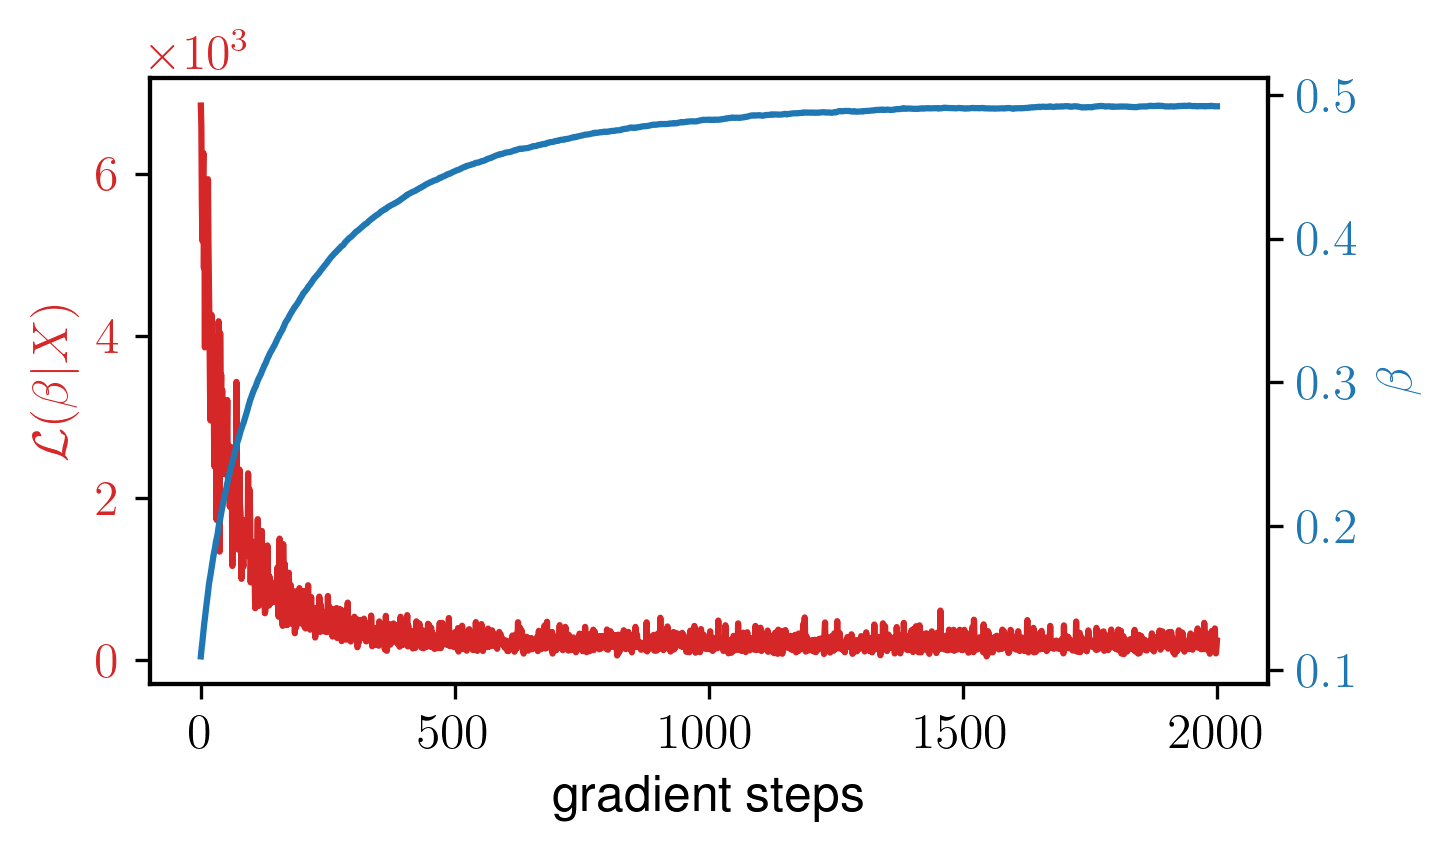

In [444]:
num_datapoints = 2000

fig, axs = plt.subplots(figsize=(5,3), dpi=300)

axs.set_xlabel("gradient steps")

color = 'tab:red'
axs.plot(np.arange(num_datapoints), np.array(dist_hist[:num_datapoints]), color=color)
axs.set_ylabel("$\mathcal{L}(\\beta|X)$", color=color)
axs.set_yscale("linear")
axs.minorticks_off()
axs.tick_params(axis='y', labelcolor=color)
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
axs.yaxis.set_major_formatter(formatter) 

color = 'tab:blue'
axs2 = axs.twinx()
axs2.set_ylabel("$\\beta$", color=color)
axs2.plot(np.arange(num_datapoints), np.array(beta_hist[:num_datapoints]), color=color)
axs2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()